In [94]:
# All imports
import pandas as pd
import numpy as np
import ast
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16

# Load data
dataVer = "review-Vermont.json.gz"
dataMeta = "meta-Vermont.json.gz"

df_meta = pd.read_json(dataMeta, lines=True, compression="gzip")
df_ver = pd.read_json(dataVer, lines=True, compression="gzip")


In [95]:
# Merge review and metadata dataframes
df = df_ver.merge(df_meta, on="gmap_id", how="left")

# Remove rows with missing text
print("Before removing missing text:", len(df))
df = df.dropna(subset=["text"])
print("After removing missing text:", len(df))

# Remove duplicate reviews (same user reviewing same business)
print("Before removing duplicates:", len(df))
df = df.drop_duplicates(subset=['user_id', 'gmap_id'])
print("After removing duplicates:", len(df))

# Remove unnecessary columns
useless = ["name_x", "name_y", "time", "pics", "resp", "address", "relative_results", "state", "url", "latitude", "longitude"]
maybe = ["description", "num_of_reviews"]
df = df.drop(columns=useless + maybe)

# Remove rows with missing ratings
print("Before removing missing ratings:", len(df))
df = df.dropna(subset=['rating'])
print("After removing missing ratings:", len(df))

# Save preprocessed data
df.to_csv("merged.csv", index=False)
print("Preprocessed data saved to merged.csv")

Before removing missing text: 853549
After removing missing text: 508108
Before removing duplicates: 508108
After removing duplicates: 488212
Before removing missing ratings: 488212
After removing missing ratings: 488052
Preprocessed data saved to merged.csv


In [96]:
# Display sample of preprocessed data
df.head()

,user_id,rating,text,gmap_id,category,avg_rating,price,hours,MISC
0,1.044905e+20,5.0,The Royal Group recently performed standard te...,0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",4.9,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...",{'Accessibility': ['Wheelchair accessible entr...
2,1.120627e+20,5.0,I can't say enough great things about The Roya...,0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",4.9,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...",{'Accessibility': ['Wheelchair accessible entr...
4,1.100483e+20,5.0,The Royal Group has done work for us over many...,0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",4.9,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...",{'Accessibility': ['Wheelchair accessible entr...
6,1.061744e+20,5.0,The Royal Group was fantastic to work with. I ...,0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",4.9,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...",{'Accessibility': ['Wheelchair accessible entr...
8,1.062387e+20,5.0,"Have used in different houses, installing mult...",0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",4.9,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...",{'Accessibility': ['Wheelchair accessible entr...


# II. Data Exploration and Visualization

This section provides visualizations and statistical analysis of the dataset to understand the data distribution and relationships between features.


In [97]:
# Load preprocessed data for visualization
df_viz = pd.read_csv("merged.csv")

# Basic statistics
print("Dataset Statistics:")
print(f"Total reviews: {len(df_viz):,}")
print(f"Unique users: {df_viz['user_id'].nunique():,}")
print(f"Unique businesses: {df_viz['gmap_id'].nunique():,}")
print(f"\nRating Statistics:")
print(df_viz['rating'].describe())

# Calculate text length
df_viz['text_length'] = df_viz['text'].astype(str).apply(len)
print(f"\nText Length Statistics:")
print(df_viz['text_length'].describe())


Dataset Statistics:
Total reviews: 488,052
Unique users: 203,213
Unique businesses: 10,992

Rating Statistics:
count    488052.000000
mean          4.326547
std           1.175101
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

Text Length Statistics:
count    488052.000000
mean        158.480943
std         231.423925
min           1.000000
25%          38.000000
50%          83.000000
75%         189.000000
max        6209.000000
Name: text_length, dtype: float64


## A. Rating Distribution


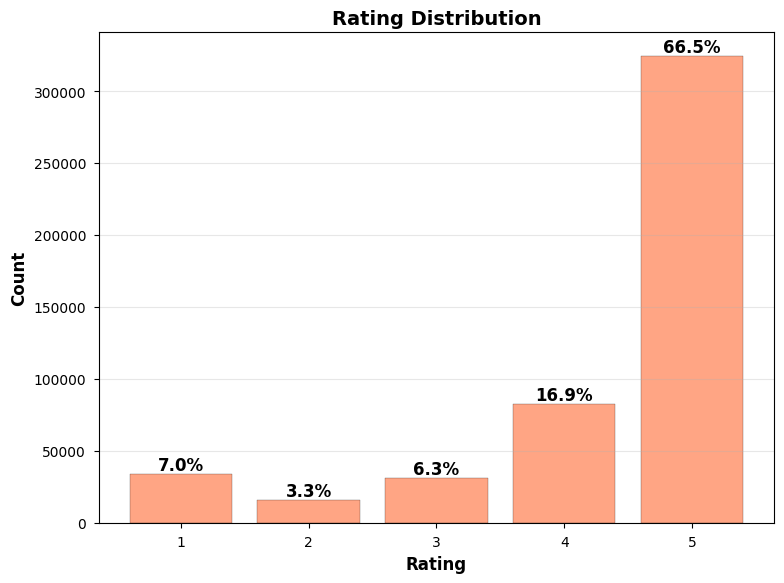


Rating Distribution:
  Rating 1: 34,002 (7.0%)
  Rating 2: 16,118 (3.3%)
  Rating 3: 30,935 (6.3%)
  Rating 4: 82,448 (16.9%)
  Rating 5: 324,549 (66.5%)


In [98]:
# Rating distribution
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Bar plot with percentages
rating_counts = df_viz['rating'].value_counts().sort_index()
rating_pct = (rating_counts / len(df_viz) * 100).round(1)
bars = ax.bar(rating_counts.index, rating_counts.values, edgecolor='black', alpha=0.7, color='coral')
ax.set_xlabel('Rating', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Rating Distribution', fontweight='bold')
ax.set_xticks([1, 2, 3, 4, 5])
ax.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for idx, val in zip(rating_counts.index, rating_counts.values):
    ax.text(idx, val, f'{rating_pct[idx]:.1f}%', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('rating_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nRating Distribution:")
for rating in sorted(rating_counts.index):
    print(f"  Rating {int(rating)}: {rating_counts[rating]:,} ({rating_pct[rating]:.1f}%)")


## B. Text Length Analysis


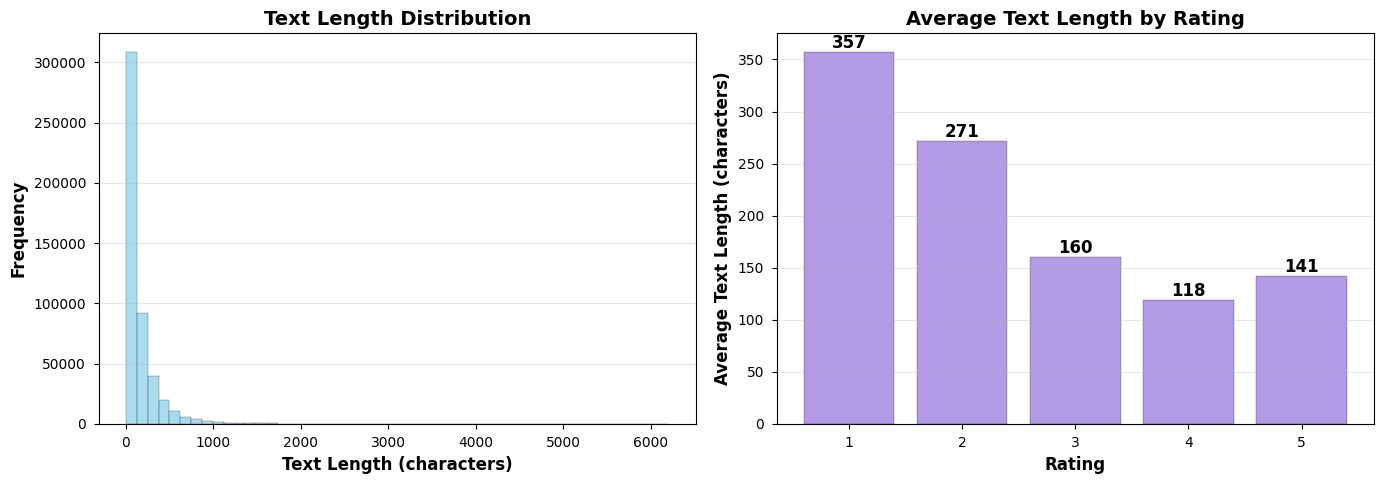


Average Text Length by Rating:
  Rating 1: 357.2 characters
  Rating 2: 272.0 characters
  Rating 3: 160.6 characters
  Rating 4: 118.9 characters
  Rating 5: 141.9 characters


In [99]:
# Text length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_viz['text_length'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Text Length (characters)', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Text Length Distribution', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Rating vs Text Length
rating_text_length = df_viz.groupby('rating')['text_length'].mean()
bars = axes[1].bar(rating_text_length.index, rating_text_length.values, 
                   edgecolor='black', alpha=0.7, color='mediumpurple')
axes[1].set_xlabel('Rating', fontweight='bold')
axes[1].set_ylabel('Average Text Length (characters)', fontweight='bold')
axes[1].set_title('Average Text Length by Rating', fontweight='bold')
axes[1].set_xticks([1, 2, 3, 4, 5])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for idx, val in zip(rating_text_length.index, rating_text_length.values):
    axes[1].text(idx, val, f'{int(val)}', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAverage Text Length by Rating:")
for rating in sorted(rating_text_length.index):
    print(f"  Rating {int(rating)}: {rating_text_length[rating]:.1f} characters")


## C. Correlation Analysis


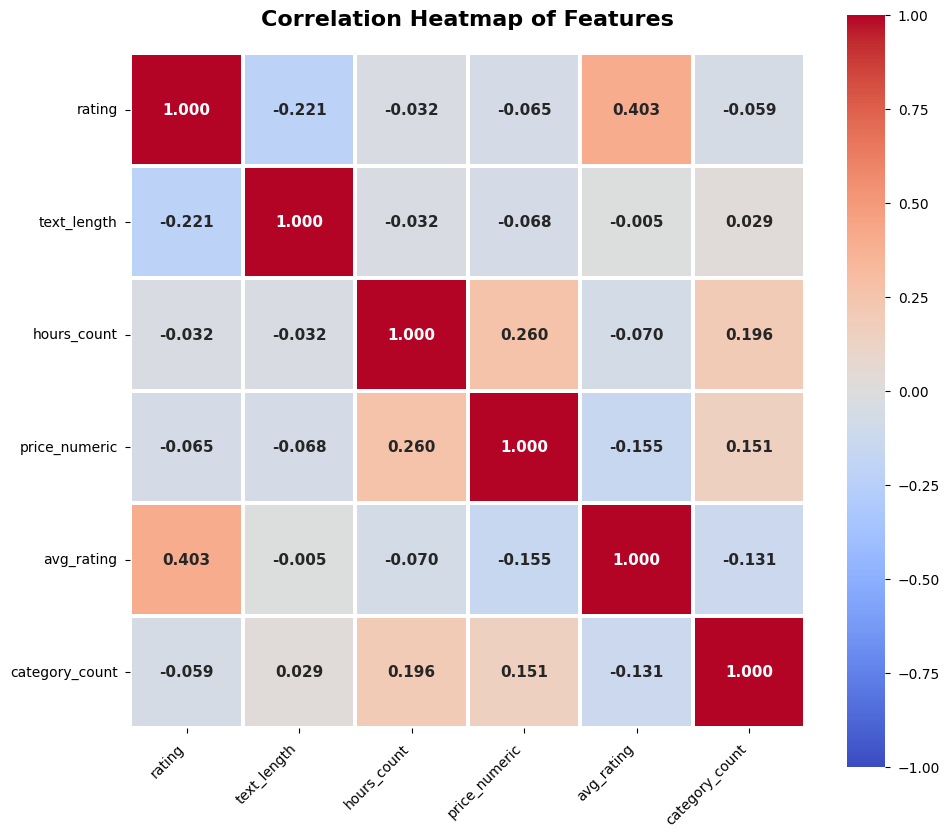


Correlation Matrix:
                rating  text_length  hours_count  price_numeric  avg_rating  \
rating           1.000       -0.221       -0.032         -0.065       0.403   
text_length     -0.221        1.000       -0.032         -0.068      -0.005   
hours_count     -0.032       -0.032        1.000          0.260      -0.070   
price_numeric   -0.065       -0.068        0.260          1.000      -0.155   
avg_rating       0.403       -0.005       -0.070         -0.155       1.000   
category_count  -0.059        0.029        0.196          0.151      -0.131   

                category_count  
rating                  -0.059  
text_length              0.029  
hours_count              0.196  
price_numeric            0.151  
avg_rating              -0.131  
category_count           1.000  

Debug Information:

Avg Rating vs Rating Correlation: 0.4025
Avg Rating Statistics:
count    488052.000000
mean          4.368640
std           0.425831
min           1.000000
25%           4.2

In [100]:
# Prepare features for correlation analysis
df_corr = df_viz.copy()

# Extract hours feature (count of open days)
hours_count = []
for hours_str in df_corr['hours']:
    if pd.isna(hours_str):
        hours_count.append(0)
    else:
        if isinstance(hours_str, str):
            try:
                hours_list = ast.literal_eval(hours_str)
            except:
                hours_list = []
        else:
            hours_list = hours_str
        
        if not isinstance(hours_list, list):
            hours_count.append(0)
        else:
            open_count = 0
            for day_info in hours_list:
                if isinstance(day_info, list) and len(day_info) >= 2:
                    if day_info[1] != 'Closed':
                        open_count += 1
            hours_count.append(open_count)

df_corr['hours_count'] = hours_count
df_corr['text_length'] = df_corr['text'].astype(str).apply(len)

# Extract price as numerical (if available)
if 'price' in df_corr.columns:
    # Convert price to numerical (e.g., '$' -> 1, '$$' -> 2, etc.)
    price_map = {None: 0, np.nan: 0, '$': 1, '$$': 2, '$$$': 3, '$$$$': 4}
    df_corr['price_numeric'] = df_corr['price'].map(price_map).fillna(0)
else:
    df_corr['price_numeric'] = 0

# Extract avg_rating (if available)
# Note: We calculate avg_rating excluding the current review to avoid data leakage
if 'avg_rating' not in df_corr.columns:
    # More efficient way: calculate total and count per business, then subtract current rating
    business_stats = df_corr.groupby('gmap_id')['rating'].agg(['sum', 'count']).reset_index()
    business_stats.columns = ['gmap_id', 'total_rating', 'count']
    
    # Merge and calculate avg_rating excluding current review
    df_corr = df_corr.merge(business_stats, on='gmap_id', how='left')
    df_corr['avg_rating'] = (df_corr['total_rating'] - df_corr['rating']) / (df_corr['count'] - 1)
    # Handle cases where count is 1 (only one review for that business)
    df_corr.loc[df_corr['count'] == 1, 'avg_rating'] = df_corr.loc[df_corr['count'] == 1, 'rating']
    df_corr = df_corr.drop(columns=['total_rating', 'count'])

# Extract category count (number of categories per business)
if 'category' in df_corr.columns:
    def count_categories(cat_str):
        if pd.isna(cat_str):
            return 0
        try:
            if isinstance(cat_str, str):
                cat_list = ast.literal_eval(cat_str)
            else:
                cat_list = cat_str
            return len(cat_list) if isinstance(cat_list, list) else 0
        except:
            return 0
    df_corr['category_count'] = df_corr['category'].apply(count_categories)
else:
    df_corr['category_count'] = 0

# Select numerical features for correlation
corr_features = ['rating', 'text_length', 'hours_count', 'price_numeric', 
                 'avg_rating', 'category_count']
df_corr_subset = df_corr[corr_features].dropna()

# Calculate correlation matrix
corr_matrix = df_corr_subset.corr()

# Create correlation heatmap (square format)
n_features = len(corr_matrix)
fig_size = max(10, n_features * 1.2)  # Adjust size based on number of features

plt.figure(figsize=(fig_size, fig_size))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1.5, cbar_kws={"shrink": 0.8}, 
            vmin=-1, vmax=1, 
            annot_kws={'fontsize': max(10, int(14 - n_features * 0.5)), 'fontweight': 'bold'},
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.title('Correlation Heatmap of Features', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelation Matrix:")
print(corr_matrix.round(3))

# Debug: Check avg_rating correlation with rating
print("\n" + "="*60)
print("Debug Information:")
print("="*60)
if 'avg_rating' in df_corr_subset.columns:
    print(f"\nAvg Rating vs Rating Correlation: {df_corr_subset['avg_rating'].corr(df_corr_subset['rating']):.4f}")
    print(f"Avg Rating Statistics:")
    print(df_corr_subset['avg_rating'].describe())


# III. Modeling

This section describes the models we implement for rating prediction. We start with simple baselines and progressively build more sophisticated models that incorporate text features and metadata.


## A. Baseline Models

We implement two baseline models to establish a performance floor:

1. **Global Mean**: Predicts the average rating across all training examples
2. **Regularized Item Bias (μ + bᵢ)**: Predicts global mean plus a regularized item bias term


In [101]:
# ============================================================================
# Data Loading and Preparation
# ============================================================================
df = pd.read_csv("merged.csv", usecols=['user_id', 'rating', 'gmap_id'])
df = df.dropna(subset=['user_id', 'rating', 'gmap_id'])
df['rating'] = df['rating'].astype(float)

# ============================================================================
# Train/Test Split (80/20)
# ============================================================================
train, test = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['rating']
)

print(f"\nData Split:")
print(f"  Train: {len(train):,} samples ({len(train)/len(df)*100:.1f}%)")
print(f"  Test:  {len(test):,} samples ({len(test)/len(df)*100:.1f}%)")

# ============================================================================
# Baseline 1: Global Mean
# ============================================================================
# Predict the average rating across all training examples
global_mean = train['rating'].mean()
preds_global = [global_mean] * len(test)
mse_global = mean_squared_error(test['rating'], preds_global)

print(f"\n{'='*60}")
print("Baseline 1: Global Mean")
print(f"{'='*60}")
print(f"Prediction: {global_mean:.4f} (constant)")
print(f"Test MSE:   {mse_global:.4f}")

# ============================================================================
# Baseline 2: Regularized Item Bias
# ============================================================================
# Formula: r̂ᵢⱼ = μ + bᵢ
# where bᵢ = (Σ(rᵢⱼ - μ)) / (nᵢ + λ)
# nᵢ: number of ratings for item i
# λ: regularization parameter
lambda_reg = 25

# Compute item statistics
item_stats = train.groupby('gmap_id').agg({
    'rating': ['sum', 'count']
}).reset_index()
item_stats.columns = ['gmap_id', 'rating_sum', 'n_i']

# Calculate bias: bᵢ = (Σrᵢⱼ - nᵢ*μ) / (nᵢ + λ)
item_stats['bias'] = (item_stats['rating_sum'] - item_stats['n_i'] * global_mean) / (item_stats['n_i'] + lambda_reg)
item_bias_dict = dict(zip(item_stats['gmap_id'], item_stats['bias']))

# Make predictions: r̂ = μ + bᵢ
preds_reg_item = []
for gmap_id in test['gmap_id']:
    if gmap_id in item_bias_dict:
        pred = global_mean + item_bias_dict[gmap_id]
    else:
        pred = global_mean  # Unseen items: use global mean (bias = 0)
    preds_reg_item.append(pred)

mse_reg_item = mean_squared_error(test['rating'], preds_reg_item)

print(f"\n{'='*60}")
print("Baseline 2: Regularized Item Bias")
print(f"{'='*60}")
print(f"Regularization (λ): {lambda_reg}")
print(f"Test MSE:           {mse_reg_item:.4f}")
print(f"{'='*60}")



Data Split:
  Train: 390,441 samples (80.0%)
  Test:  97,611 samples (20.0%)

Baseline 1: Global Mean
Prediction: 4.3265 (constant)
Test MSE:   1.3808

Baseline 2: Regularized Item Bias
Regularization (λ): 25
Test MSE:           1.2103


In [102]:
# Analysis: Why not User Mean?
# Check the distribution of reviews per user
user_review_counts = train.groupby('user_id').size()
single_review_users = (user_review_counts == 1).sum()

print(f"Total unique users in train: {len(user_review_counts)}")
print(f"Users with only 1 review: {single_review_users} ({100*single_review_users/len(user_review_counts):.2f}%)")
print(f"Users with 2+ reviews: {len(user_review_counts) - single_review_users} ({100*(len(user_review_counts)-single_review_users)/len(user_review_counts):.2f}%)")
print("\nSince most users have only 1 review, user mean would not be informative.")


Total unique users in train: 174161
Users with only 1 review: 121350 (69.68%)
Users with 2+ reviews: 52811 (30.32%)

Since most users have only 1 review, user mean would not be informative.


## B. Text-based Linear Model (Main Model #1)

**Intuition**: The sentiment and expressions in text are most directly connected to ratings. Words, phrases, and sentiment expressions contained in review text provide key information for predicting the ratings assigned by users.

We use:
- **TF-IDF vectorization** to convert text into numerical features
- **Ridge Regression** for regularization and to handle the high-dimensional feature space


In [103]:
# ============================================================================
# Data Loading and Preparation
# ============================================================================
df = pd.read_csv("merged.csv", usecols=['text', 'rating'])
df = df.dropna(subset=['text', 'rating'])
df['text'] = df['text'].astype(str)
df['rating'] = df['rating'].astype(float)

# ============================================================================
# Train/Validation/Test Split (70/15/15)
# ============================================================================
# Step 1: Separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    df['text'], df['rating'], 
    test_size=0.15, 
    random_state=42, 
    stratify=df['rating']
)

# Step 2: Split remaining 85% into train (70%) and validation (15%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.15/0.85,  # ~17.6% of 85% = 15% of total
    random_state=42, 
    stratify=y_temp
)

print(f"\nData Split:")
print(f"  Train:      {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"  Validation: {len(X_val):,} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"  Test:       {len(X_test):,} samples ({len(X_test)/len(df)*100:.1f}%)")

# ============================================================================
# Feature Engineering: TF-IDF Vectorization
# ============================================================================
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),    # Unigrams and bigrams
    min_df=2,              # Ignore terms in < 2 documents
    max_df=0.95            # Ignore terms in > 95% of documents
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

print(f"\nTF-IDF Features:")
print(f"  Shape: {X_train_tfidf.shape}")
print(f"  Vocabulary size: {len(tfidf.vocabulary_):,}")

# ============================================================================
# Hyperparameter Tuning on Validation Set
# ============================================================================
alpha_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
best_alpha = 1.0
best_val_mse = float('inf')

print(f"\n{'='*60}")
print("Hyperparameter Tuning (Validation Set)")
print(f"{'='*60}")
for alpha in alpha_values:
    model_temp = Ridge(alpha=alpha)
    model_temp.fit(X_train_tfidf, y_train)
    y_pred_val = model_temp.predict(X_val_tfidf)
    val_mse = mean_squared_error(y_val, y_pred_val)
    print(f"  Alpha = {alpha:4.1f}:  Validation MSE = {val_mse:.4f}")
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        best_alpha = alpha

print(f"\nBest hyperparameters:")
print(f"  Alpha = {best_alpha:.1f}")
print(f"  Validation MSE = {best_val_mse:.4f}")

# ============================================================================
# Final Model Training and Evaluation
# ============================================================================
# Train on full training set with best hyperparameters
model_text = Ridge(alpha=best_alpha)
model_text.fit(X_train_tfidf, y_train)

# Evaluate on test set (final evaluation only)
y_pred_text = model_text.predict(X_test_tfidf)
mse_text = mean_squared_error(y_test, y_pred_text)

print(f"\n{'='*60}")
print(f"Final Model Performance (Test Set)")
print(f"{'='*60}")
print(f"Model: Text-based (TF-IDF + Ridge)")
print(f"Alpha: {best_alpha:.1f}")
print(f"Test MSE: {mse_text:.4f}")
print(f"{'='*60}")



Data Split:
  Train:      341,634 samples (70.0%)
  Validation: 73,208 samples (15.0%)
  Test:       73,208 samples (15.0%)

TF-IDF Features:
  Shape: (341634, 50000)
  Vocabulary size: 50,000

Hyperparameter Tuning (Validation Set)
  Alpha =  0.1:  Validation MSE = 0.5075
  Alpha =  0.5:  Validation MSE = 0.4832
  Alpha =  1.0:  Validation MSE = 0.4740
  Alpha =  2.0:  Validation MSE = 0.4700
  Alpha =  5.0:  Validation MSE = 0.4772
  Alpha = 10.0:  Validation MSE = 0.4942

Best hyperparameters:
  Alpha = 2.0
  Validation MSE = 0.4700

Final Model Performance (Test Set)
Model: Text-based (TF-IDF + Ridge)
Alpha: 2.0
Test MSE: 0.4699


## C. Text + Metadata Model

This model combines text features with metadata to capture both semantic content and contextual information about the business.

**Features**:
- **TF-IDF(text)**: Text vectorization
- **avg_rating**: Average rating of the business (excluding current review) - high correlation feature
- **text_length**: Length of review text - correlation feature

We use **Ridge Regression** for this model.


In [104]:
# ============================================================================
# Data Loading and Preparation
# ============================================================================
df = pd.read_csv("merged.csv", usecols=['text', 'rating', 'gmap_id'])
df = df.dropna(subset=['text', 'rating', 'gmap_id'])
df['text'] = df['text'].astype(str)
df['rating'] = df['rating'].astype(float)

# ============================================================================
# Train/Validation/Test Split (70/15/15)
# ============================================================================
# Step 1: Separate test set (15%)
df_temp, df_test = train_test_split(
    df, 
    test_size=0.15, 
    random_state=42, 
    stratify=df['rating']
)

# Step 2: Split remaining 85% into train (70%) and validation (15%)
df_train, df_val = train_test_split(
    df_temp, 
    test_size=0.15/0.85,  # ~17.6% of 85% = 15% of total
    random_state=42, 
    stratify=df_temp['rating']
)

print(f"\nData Split:")
print(f"  Train:      {len(df_train):,} samples ({len(df_train)/len(df)*100:.1f}%)")
print(f"  Validation: {len(df_val):,} samples ({len(df_val)/len(df)*100:.1f}%)")
print(f"  Test:       {len(df_test):,} samples ({len(df_test)/len(df)*100:.1f}%)")

# ============================================================================
# Feature Engineering
# ============================================================================

# --- Feature 1: TF-IDF Vectorization ---
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_train_tfidf = tfidf.fit_transform(df_train['text'])
X_val_tfidf = tfidf.transform(df_val['text'])
X_test_tfidf = tfidf.transform(df_test['text'])

print(f"\nTF-IDF Features:")
print(f"  Shape: {X_train_tfidf.shape}")

# --- Feature 2: Average Rating (excluding current review) ---
# Calculate business statistics from train set only (avoid data leakage)
business_stats = df_train.groupby('gmap_id')['rating'].agg(['sum', 'count']).reset_index()
business_stats.columns = ['gmap_id', 'total_rating', 'count']

# Train set: exclude current review
df_train_merged = df_train.merge(business_stats, on='gmap_id', how='left')
df_train_merged['avg_rating'] = (df_train_merged['total_rating'] - df_train_merged['rating']) / (df_train_merged['count'] - 1)
df_train_merged.loc[df_train_merged['count'] == 1, 'avg_rating'] = df_train_merged.loc[df_train_merged['count'] == 1, 'rating']
avg_rating_train = df_train_merged['avg_rating'].fillna(df_train['rating'].mean()).values

# Validation/Test sets: use train statistics only
df_val_merged = df_val.merge(business_stats, on='gmap_id', how='left')
df_val_merged['avg_rating'] = df_val_merged['total_rating'] / df_val_merged['count']
avg_rating_val = df_val_merged['avg_rating'].fillna(df_train['rating'].mean()).values

df_test_merged = df_test.merge(business_stats, on='gmap_id', how='left')
df_test_merged['avg_rating'] = df_test_merged['total_rating'] / df_test_merged['count']
avg_rating_test = df_test_merged['avg_rating'].fillna(df_train['rating'].mean()).values

# --- Feature 3: Text Length ---
text_length_train = df_train['text'].str.len().values
text_length_val = df_val['text'].str.len().values
text_length_test = df_test['text'].str.len().values

print(f"\nMetadata Features:")
print(f"  Avg Rating - Train: {np.mean(avg_rating_train):.2f}, Val: {np.mean(avg_rating_val):.2f}, Test: {np.mean(avg_rating_test):.2f}")
print(f"  Text Length - Train: {np.mean(text_length_train):.1f}, Val: {np.mean(text_length_val):.1f}, Test: {np.mean(text_length_test):.1f}")

# --- Combine and Scale Features ---
metadata_train = np.column_stack([avg_rating_train, text_length_train])
metadata_val = np.column_stack([avg_rating_val, text_length_val])
metadata_test = np.column_stack([avg_rating_test, text_length_test])

# Scale metadata features (fit only on train to avoid data leakage)
scaler = StandardScaler()
metadata_train_scaled = scaler.fit_transform(metadata_train)
metadata_val_scaled = scaler.transform(metadata_val)
metadata_test_scaled = scaler.transform(metadata_test)

# Combine TF-IDF (sparse) + metadata (dense)
X_train_combined = hstack([X_train_tfidf, metadata_train_scaled])
X_val_combined = hstack([X_val_tfidf, metadata_val_scaled])
X_test_combined = hstack([X_test_tfidf, metadata_test_scaled])

print(f"\nCombined Features:")
print(f"  Train: {X_train_combined.shape}")
print(f"  Val:   {X_val_combined.shape}")
print(f"  Test:  {X_test_combined.shape}")

# ============================================================================
# Hyperparameter Tuning on Validation Set
# ============================================================================
alpha_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
best_alpha = 1.0
best_val_mse = float('inf')

print(f"\n{'='*60}")
print("Hyperparameter Tuning (Validation Set)")
print(f"{'='*60}")
for alpha in alpha_values:
    model_temp = Ridge(alpha=alpha)
    model_temp.fit(X_train_combined, df_train['rating'])
    y_pred_val = model_temp.predict(X_val_combined)
    val_mse = mean_squared_error(df_val['rating'], y_pred_val)
    print(f"  Alpha = {alpha:4.1f}:  Validation MSE = {val_mse:.4f}")
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        best_alpha = alpha

print(f"\nBest hyperparameters:")
print(f"  Alpha = {best_alpha:.1f}")
print(f"  Validation MSE = {best_val_mse:.4f}")

# ============================================================================
# Final Model Training and Evaluation
# ============================================================================
# Train on full training set with best hyperparameters
model_ridge = Ridge(alpha=best_alpha)
model_ridge.fit(X_train_combined, df_train['rating'])

# Evaluate on test set (final evaluation only)
y_pred_ridge = model_ridge.predict(X_test_combined)
mse_ridge = mean_squared_error(df_test['rating'], y_pred_ridge)

print(f"\n{'='*60}")
print(f"Final Model Performance (Test Set)")
print(f"{'='*60}")
print(f"Model: Text + Metadata (TF-IDF + avg_rating + text_length + Ridge)")
print(f"Alpha: {best_alpha:.1f}")
print(f"Test MSE: {mse_ridge:.4f}")
print(f"{'='*60}")



Data Split:
  Train:      341,634 samples (70.0%)
  Validation: 73,208 samples (15.0%)
  Test:       73,208 samples (15.0%)

TF-IDF Features:
  Shape: (341634, 50000)

Metadata Features:
  Avg Rating - Train: 4.33, Val: 4.33, Test: 4.33
  Text Length - Train: 158.7, Val: 159.4, Test: 156.6

Combined Features:
  Train: (341634, 50002)
  Val:   (73208, 50002)
  Test:  (73208, 50002)

Hyperparameter Tuning (Validation Set)
  Alpha =  0.1:  Validation MSE = 0.4988
  Alpha =  0.5:  Validation MSE = 0.4751
  Alpha =  1.0:  Validation MSE = 0.4660
  Alpha =  2.0:  Validation MSE = 0.4620
  Alpha =  5.0:  Validation MSE = 0.4686
  Alpha = 10.0:  Validation MSE = 0.4845

Best hyperparameters:
  Alpha = 2.0
  Validation MSE = 0.4620

Final Model Performance (Test Set)
Model: Text + Metadata (TF-IDF + avg_rating + text_length + Ridge)
Alpha: 2.0
Test MSE: 0.4621


## D. LinearSVR Model

**Explanation**: Linear Support Vector Regression (LinearSVR) is a linear model that uses support vector machines for regression tasks. It can handle high-dimensional sparse data well and often performs better than Ridge regression for certain types of text classification problems.

We use **LinearSVR** with TF-IDF features for rating prediction.


In [105]:
# ============================================================================
# Data Loading and Preparation
# ============================================================================
df = pd.read_csv("merged.csv", usecols=['text', 'rating'])
df = df.dropna(subset=['text', 'rating'])
df['text'] = df['text'].astype(str)
df['rating'] = df['rating'].astype(float)

# ============================================================================
# Train/Validation/Test Split (70/15/15)
# ============================================================================
# Step 1: Separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    df['text'], df['rating'], 
    test_size=0.15, 
    random_state=42, 
    stratify=df['rating']
)

# Step 2: Split remaining 85% into train (70%) and validation (15%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.15/0.85,  # ~17.6% of 85% = 15% of total
    random_state=42, 
    stratify=y_temp
)

print(f"\nData Split:")
print(f"  Train:      {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"  Validation: {len(X_val):,} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"  Test:       {len(X_test):,} samples ({len(X_test)/len(df)*100:.1f}%)")

# ============================================================================
# Feature Engineering: TF-IDF Vectorization
# ============================================================================
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),    # Unigrams and bigrams
    min_df=2,              # Ignore terms in < 2 documents
    max_df=0.95            # Ignore terms in > 95% of documents
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

print(f"\nTF-IDF Features:")
print(f"  Shape: {X_train_tfidf.shape}")
print(f"  Vocabulary size: {len(tfidf.vocabulary_):,}")

# ============================================================================
# Hyperparameter Tuning on Validation Set
# ============================================================================
# C: Regularization parameter (inverse of regularization strength)
# epsilon: Epsilon-tube (no penalty within this range)
C_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
epsilon_values = [0.0, 0.1, 0.2]
best_C = 1.0
best_epsilon = 0.0
best_val_mse = float('inf')

print(f"\n{'='*60}")
print("Hyperparameter Tuning (Validation Set)")
print(f"{'='*60}")
for C in C_values:
    for epsilon in epsilon_values:
        model_temp = LinearSVR(C=C, epsilon=epsilon, max_iter=1000, random_state=42)
        model_temp.fit(X_train_tfidf, y_train)
        y_pred_val = model_temp.predict(X_val_tfidf)
        y_pred_val = np.clip(y_pred_val, 1.0, 5.0)  # Clip to valid rating range
        val_mse = mean_squared_error(y_val, y_pred_val)
        print(f"  C = {C:4.1f}, epsilon = {epsilon:.1f}:  Validation MSE = {val_mse:.4f}")
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_C = C
            best_epsilon = epsilon

print(f"\nBest hyperparameters:")
print(f"  C = {best_C:.1f}")
print(f"  epsilon = {best_epsilon:.1f}")
print(f"  Validation MSE = {best_val_mse:.4f}")

# ============================================================================
# Final Model Training and Evaluation
# ============================================================================
# Train on full training set with best hyperparameters
model_svr = LinearSVR(C=best_C, epsilon=best_epsilon, max_iter=1000, random_state=42)
model_svr.fit(X_train_tfidf, y_train)

# Evaluate on test set (final evaluation only)
y_pred_svr = model_svr.predict(X_test_tfidf)
y_pred_svr = np.clip(y_pred_svr, 1.0, 5.0)  # Clip to valid rating range
mse_svr = mean_squared_error(y_test, y_pred_svr)

print(f"\n{'='*60}")
print(f"Final Model Performance (Test Set)")
print(f"{'='*60}")
print(f"Model: LinearSVR (TF-IDF + LinearSVR)")
print(f"C: {best_C:.1f}, epsilon: {best_epsilon:.1f}")
print(f"Test MSE: {mse_svr:.4f}")
print(f"{'='*60}")



Data Split:
  Train:      341,634 samples (70.0%)
  Validation: 73,208 samples (15.0%)
  Test:       73,208 samples (15.0%)

TF-IDF Features:
  Shape: (341634, 50000)
  Vocabulary size: 50,000

Hyperparameter Tuning (Validation Set)
  C =  0.1, epsilon = 0.0:  Validation MSE = 0.5812
  C =  0.1, epsilon = 0.1:  Validation MSE = 0.5430
  C =  0.1, epsilon = 0.2:  Validation MSE = 0.5165
  C =  0.5, epsilon = 0.0:  Validation MSE = 0.5221
  C =  0.5, epsilon = 0.1:  Validation MSE = 0.4920
  C =  0.5, epsilon = 0.2:  Validation MSE = 0.4722
  C =  1.0, epsilon = 0.0:  Validation MSE = 0.5144
  C =  1.0, epsilon = 0.1:  Validation MSE = 0.4874
  C =  1.0, epsilon = 0.2:  Validation MSE = 0.4699


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  C =  2.0, epsilon = 0.0:  Validation MSE = 0.5139
  C =  2.0, epsilon = 0.1:  Validation MSE = 0.4890
  C =  2.0, epsilon = 0.2:  Validation MSE = 0.4735


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  C =  5.0, epsilon = 0.0:  Validation MSE = 0.5201


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  C =  5.0, epsilon = 0.1:  Validation MSE = 0.4953


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  C =  5.0, epsilon = 0.2:  Validation MSE = 0.4811


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  C = 10.0, epsilon = 0.0:  Validation MSE = 0.5251


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  C = 10.0, epsilon = 0.1:  Validation MSE = 0.5000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  C = 10.0, epsilon = 0.2:  Validation MSE = 0.4866

Best hyperparameters:
  C = 1.0
  epsilon = 0.2
  Validation MSE = 0.4699

Final Model Performance (Test Set)
Model: LinearSVR (TF-IDF + LinearSVR)
C: 1.0, epsilon: 0.2
Test MSE: 0.4682


## E. Model Comparison

Below is a comprehensive comparison of all models we implemented:


In [106]:
# ============================================================================
# Model Comparison
# ============================================================================
results = {
    'Model': [
        'Global Mean (Baseline)',
        'Regularized Item Bias (Baseline)',
        'LinearSVR',
        'Text-based (TF-IDF + Ridge)',
        'Text + Metadata (Ridge)',
    ],
    'MSE': [
        mse_global,
        mse_reg_item,
        mse_svr,
        mse_text,
        mse_ridge,
    ]
}

comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values('MSE')

print(f"\n{'='*80}")
print("MODEL COMPARISON (Sorted by MSE - Lower is Better)")
print(f"{'='*80}")
print(comparison_df.to_string(index=False))
print(f"{'='*80}")

comparison_df



MODEL COMPARISON (Sorted by MSE - Lower is Better)
                           Model      MSE
         Text + Metadata (Ridge) 0.462094
                       LinearSVR 0.468170
     Text-based (TF-IDF + Ridge) 0.469852
Regularized Item Bias (Baseline) 1.210268
          Global Mean (Baseline) 1.380830


,Model,MSE
4,Text + Metadata (Ridge),0.462094
2,LinearSVR,0.468170
3,Text-based (TF-IDF + Ridge),0.469852
1,Regularized Item Bias (Baseline),1.210268
0,Global Mean (Baseline),1.380830


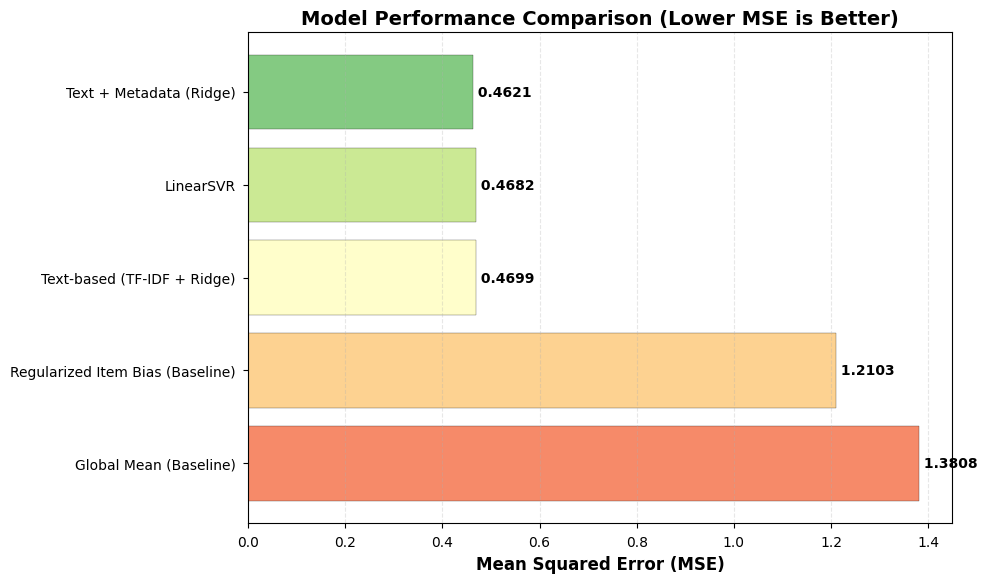

In [107]:
# ============================================================================
# Model Performance Visualization
# ============================================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Sort by MSE (best to worst)
comparison_sorted = comparison_df.sort_values('MSE')

# Color gradient: green (best) to red (worst)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(comparison_sorted)))
bars = ax.barh(
    comparison_sorted['Model'], 
    comparison_sorted['MSE'], 
    color=colors, 
    edgecolor='black', 
    alpha=0.8
)

# Formatting
ax.set_xlabel('Mean Squared Error (MSE)', fontweight='bold', fontsize=12)
ax.set_title('Model Performance Comparison (Lower MSE is Better)', fontweight='bold', fontsize=14)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.invert_yaxis()  # Best model on top

# Add value labels on bars
for i, (idx, val) in enumerate(zip(comparison_sorted.index, comparison_sorted['MSE'])):
    ax.text(val, i, f' {val:.4f}', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
